# Generative Adversarial Networks

Попытаемся сгенерировать изображения кроссовок с помощью генеративно-состязательной сети.

Т.к. GAN'ы на текущий момент имеют ограничения по генерации изображений с высоким разрешением, разобьём задачу на две: использование простой сети для генерации низкокачественных изображений из некоторого шума, затем улучшим качество изображений, используя другую сеть.

In [ ]:
import os
import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

In [2]:
from tensorflow import keras
L = keras.layers
K = keras.backend

In [1]:
# !unzip data.zip

In [4]:
dataset_root = "./data"
images_dir = "images"
image_filenames = sorted(os.listdir(os.path.join(dataset_root, images_dir)))
len(image_filenames)

5729

# 1. Генерация изображений

Будем генерировать изображения 28x28 из шума, полученного из нормального распределения с матожиданием 0 и дисперсией 1.

In [5]:
IMAGE_SIZE = (28, 28)

In [6]:
def img2data(image):
    data = 2 * image - 1
    return data

def data2img(data):
    image = 0.5 * data + 0.5
    return image

def load_image(filename, target_size=None):
    image_bgr = cv2.imread(os.path.join(dataset_root, images_dir, filename))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    if target_size is not None:
        image_rgb = cv2.resize(image_rgb, target_size)

    image_rgb = (image_rgb / 255).astype(np.float32)
    return image_rgb

In [7]:
all_data = np.stack([
    img2data(load_image(fn, IMAGE_SIZE)) 
    for fn in tqdm.tqdm(image_filenames, position=0)
])
assert all_data.shape[1:] == IMAGE_SIZE + (3,)

100%|██████████| 5729/5729 [00:03<00:00, 1490.56it/s]


In [8]:
def sample_data(batch_size):
    batch_ids = np.random.choice(len(all_data), size=batch_size)
    return all_data[batch_ids]

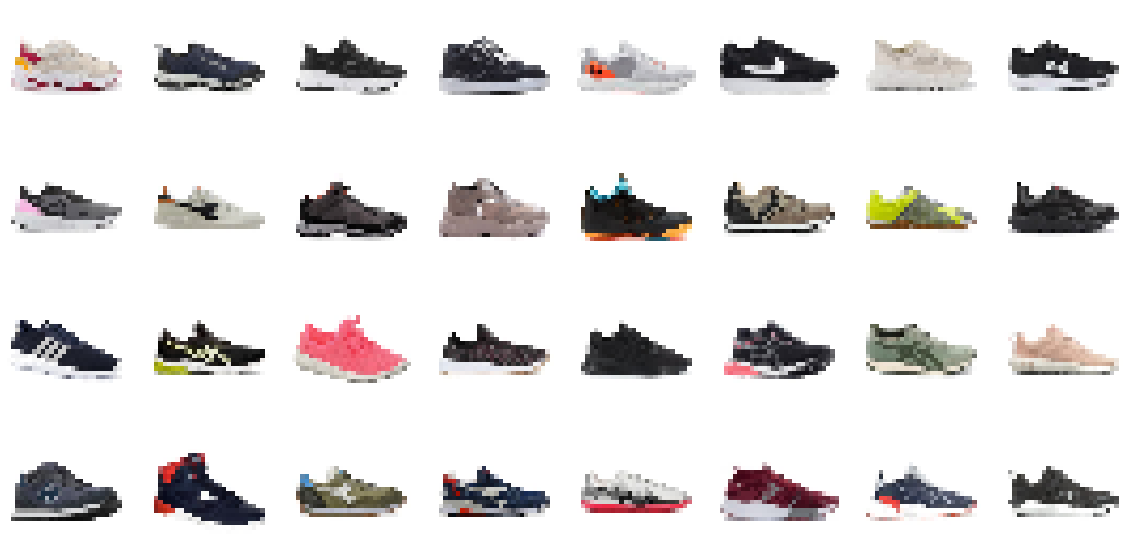

In [9]:
def visualize_images(data, n_rows, n_cols):
    n_samples = n_rows * n_cols

    if len(data) != n_samples:
        sample_indices = np.random.choice(len(data), n_samples, replace=len(data) < n_samples)
    else:
        sample_indices = np.arange(len(data)).astype(int)

    plt.figure(figsize=(int(2.5 * n_cols), int(2.5 * n_rows)))
    for i, sample_index in enumerate(sample_indices):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(data2img(data[sample_index]))
        plt.axis("off")
    plt.show()

# draw random images
visualize_images(sample_data(32), 4, 8)

## Случайный шум
Создадим TensorFlow `Tensor`, содержащий гауссовский шум с shape'ом `[batch_size, dim]`:

In [10]:
NOISE_SIZE = 100

In [11]:
def sample_noise(batch_size):
    return np.random.randn(batch_size, NOISE_SIZE)

## Fully connected GAN

### Generator


Первый шаг - создание генератора. Для создания модели будем использовать слои из `tf.keras.layers`.

Архитектура:
 * Полносвязный слой с выходом размера 1024
 * ReLU
 * Полносвязный слой с выходом размера 1024
 * ReLU
 * Полносвязный слой с выходом размера 28 x 28 x 3
 * Reshape в (28, 28, 3)
 * TanH(для нормализации каждого элемента в отрезок [-1,1])

In [12]:
import tensorflow as tf

def build_fc_generator():
    inputs = L.Input(shape=(NOISE_SIZE,))

    x = tf.keras.layers.Dense(1024, activation='relu')(inputs)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(28 * 28 * 3, activation='tanh')(x)
    
    outputs = tf.keras.layers.Reshape((28, 28, 3))(x)

    return keras.models.Model(inputs=inputs, outputs=outputs, name="FCGAN_gen")

In [13]:
# Build FCGAN generator
generator = build_fc_generator()
generator.summary()

Model: "FCGAN_gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              103424    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 2352)              2410800   
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 3)         0         
Total params: 3,563,824
Trainable params: 3,563,824
Non-trainable params: 0
_________________________________________________________________


In [14]:
noise = sample_noise(32)
fake_data = generator.predict(noise)
assert fake_data.shape[1:] == IMAGE_SIZE + (3,)

### Дискриминатор

Теперь построим дискриминатор.

Architecture:
 * Flatten
 * Полносвязный слой с выходом размера 256
 * Leaky ReLU(0.01)
 * Полносвязный слой с выходом размера 256
 * Leaky ReLU(0.01)
 * Полносвязный слой с выходом размера 1
 * Сигмоида(чтобы получить вероятность в пределах [0; 1])

Выход дискриминатора должен иметь shape `(batch_size, 1)`, и содержать числа, соответствующие вероятностям, является ли изображение подлинным или подделкой.

In [15]:
def build_fc_discriminator():
    inputs = L.Input(shape=IMAGE_SIZE + (3,))
    
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x) 

    return keras.models.Model(inputs, outputs, name="FCGAN_disc")

In [16]:
# Build FCGAN discriminator
discriminator = build_fc_discriminator()
discriminator.summary()

Model: "FCGAN_disc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               602368    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2

In [17]:
fake_probas = discriminator.predict(fake_data)
assert fake_probas.shape[1:] == (1,)

## GAN Loss

Вычислим loss для генератора и дискриминатора. 

Loss генератора:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
и дискриминатора :
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

In [18]:
def generator_gan_loss(y_true, y_pred):
    fake_probas = y_pred
    logp_fake_is_real = K.log(fake_probas)
    loss = -K.mean(logp_fake_is_real)
    return loss

In [19]:
loss = generator_gan_loss(None, fake_probas)
assert loss.shape[1:] == ()
K.eval(loss)

0.6070694

In [20]:
def discriminator_gan_loss(y_true, y_pred, eps=K.epsilon()):
    probas = K.clip(y_pred, eps, 1 - eps) # clip to avoid overflow

    is_real = y_true
    is_fake = 1 - y_true

    logp_real_is_real = tf.boolean_mask(K.log(y_pred), is_real == 1)
    logp_fake_is_fake = tf.boolean_mask(K.log(1 - y_pred), is_fake == 1)

    loss = tf.cond(tf.greater(K.sum(is_real), 0), lambda: -K.mean(logp_real_is_real), lambda: 0.)
    loss += tf.cond(tf.greater(K.sum(is_fake), 0), lambda: - K.mean(logp_fake_is_fake), lambda: 0.)

    return loss / 2

In [21]:
real_data = sample_data(32)

real_and_fake_data = np.concatenate((real_data, fake_data))
real_and_fake_labels = [1] * len(real_data) + [0] * len(fake_data)

real_and_fake_probas = discriminator.predict(real_and_fake_data)

loss = discriminator_gan_loss(K.variable(real_and_fake_labels), K.variable(real_and_fake_probas))
assert loss.shape[1:] == ()
K.eval(loss)

0.5432868

In [22]:
generator = build_fc_generator()
discriminator = build_fc_discriminator()

discriminator_opt = keras.optimizers.Adam(0.0001, 0.5)
discriminator_loss = discriminator_gan_loss

discriminator.compile(
    optimizer=discriminator_opt,
    loss=discriminator_loss
)

In [23]:
# we only want to be able to train generation for the combined model
discriminator.trainable = False

combined = keras.models.Model(
    inputs=generator.inputs,
    outputs=discriminator(generator.outputs),
    name="FCGAN_combined"
)

generator_opt = keras.optimizers.Adam(0.0001, 0.5)
generator_loss = generator_gan_loss

combined.compile(
    optimizer=generator_opt,
    loss=generator_loss
)

**Utility**

In [24]:
def sample_images(n_rows, n_cols):
    batch_size = n_rows * n_cols
    data = generator.predict(sample_noise(batch_size))
    visualize_images(data, n_rows, n_cols)


def sample_probas(num_samples, batch_size=1):
    plt.title("Fake vs real distribution")
    
    real_probas, fake_probas = [], []
    
    for _ in range(0, num_samples, batch_size):
        real_data = sample_data(batch_size)
        fake_data = generator.predict(sample_noise(batch_size))
        
        real_probas.append(discriminator.predict(real_data))
        fake_probas.append(discriminator.predict(fake_data))

    real_probas = np.concatenate(real_probas, 0)[:num_samples]
    fake_probas = np.concatenate(fake_probas, 0)[:num_samples]

    plt.hist(real_probas, label="D(x)", color='g', alpha=0.5, range=[0,1])
    plt.hist(fake_probas, label="D(G(z))", color='r', alpha=0.5, range=[0,1])
    plt.legend(loc="best")
    plt.show()

### Training
Обучение генератора и дискриминатора и вывод результата каждые $N$ итераций.

Epoch: 9999


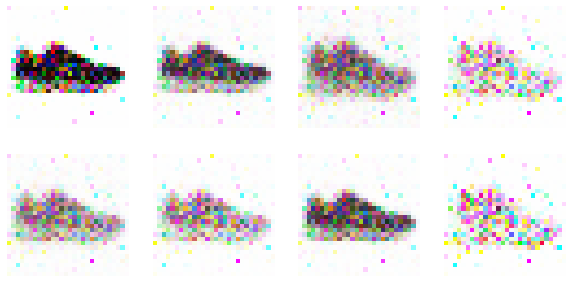

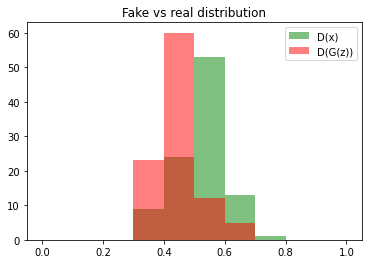

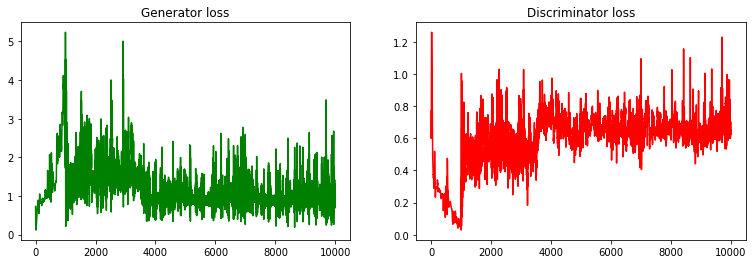

In [25]:
batch_size = 128
epochs = 10000

history = {"gen": [], "disc": []}

for epoch in range(epochs):

    # Generate a new batch of noise
    noise = sample_noise(batch_size)

    # Get a batch of real images
    real_data = sample_data(batch_size)

    # Generate a batch of fake images
    # Hint: use .predict() method
    fake_data = generator.predict(noise)

    # Run discriminator on both real and fake images
    # Hint: use .train_on_batch() method 
    data = tf.concat([real_data, fake_data], 0)
    labels = tf.concat([tf.ones(batch_size), tf.zeros(batch_size)], 0)
    loss_d = discriminator.train_on_batch(data, labels)

    # Make another noise batch
    noise = sample_noise(batch_size)

    # Train the generator to trick the discriminator
    # For the generator, we want all the {fake, not-fake} labels 
    # to say not-fake
    # Hint: use combined model
    loss_g = combined.train_on_batch(noise, tf.ones(batch_size))

    history["disc"].append(loss_d)
    history["gen"].append(loss_g)

    if (epoch + 1) % 100 == 0:
        clear_output(wait=True)
        print("Epoch:", epoch)
        
        sample_images(2, 4)
        sample_probas(100, batch_size)

        time = np.arange(epoch + 1)

        fig, ax = plt.subplots(ncols=2, figsize=(13, 4))
        ax[0].set_title("Generator loss")
        ax[0].plot(time, history["gen"], color='g')
        ax[1].set_title("Discriminator loss")
        ax[1].plot(time, history["disc"], color='r')
        plt.show()

## Deep Convolutional GANs
В первой части заимплиментим стандартную схему от автора GAN Ian Goodfellow с некоторыми идеями из [DCGAN](https://arxiv.org/abs/1511.06434), когда генератор и дискриминатор являются свёрточными сетями.

### Генератор

Архитектура:
 * Полносвязный слой размера 128x7x7
 * Reshape в (7, 7, 128)
 * ReLU
 * UpSampling2D(2)
 * Conv2D: 3x3, filters=128, padding="same"
 * Batch Normalization with momentum(0.8)
 * ReLU
 * UpSampling2D(2)
 * Conv2D: 3x3, filters=64, padding="same"
 * Batch Normalization with momentum(0.8)
 * ReLU
 * Conv2D: 3x3, filters=3, padding="same"
 * TanH(для сведения каждого элемента на выходе в [-1,1])

In [26]:
def build_dc_generator():
    inputs = L.Input(shape=(NOISE_SIZE,))

    x = L.Dense(128 * 7 * 7, activation='relu')(inputs)
    x = L.Reshape((7, 7, 128))(x)
    
    x = L.UpSampling2D()(x)
    x = L.Conv2D(128, 3, padding='same')(x)
    x = L.BatchNormalization(momentum=0.8)(x)
    x = L.ReLU()(x)

    x = L.UpSampling2D()(x)
    x = L.Conv2D(64, 3, padding='same')(x)
    x = L.BatchNormalization(momentum=0.8)(x)
    x = L.ReLU()(x)
    
    outputs = L.Conv2D(3, 3, padding='same', activation='tanh')(x)
    
    return keras.models.Model(inputs=inputs, outputs=outputs, name="DCGAN_gen")

In [27]:
# Build DCGAN generator
generator = build_dc_generator()
generator.summary()

Model: "DCGAN_gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 128)       0 

In [28]:
noise = sample_noise(32)
fake_data = generator.predict(noise)
assert fake_data.shape[1:] == IMAGE_SIZE + (3,)

### Дискриминатор

Архитектура:
 * Conv2D: 3x3, filters=32, strides=2, padding="same"
 * Leaky ReLU(0.2)
 * Dropout(0.25)
 * Conv2D: 3x3, filters=64, strides=2, padding="same"
 * Zero Padding: ((0, 1), (0, 1))
 * Batch Normalization with momentum(0.8)
 * Leaky ReLU(0.2)
 * Dropout(0.25)
 * Conv2D: 3x3, filters=128, strides=2, padding="same"
 * Batch Normalization with momentum(0.8)
 * Leaky ReLU(0.2)
 * Dropout(0.25)
 * Conv2D: 3x3, filters=256, strides=2, padding="same"
 * Batch Normalization with momentum(0.8)
 * Leaky ReLU(0.2)
 * Dropout(0.25)
 * Flatten
 * Fully connected layer with output size 1
 * Сигмоида

In [29]:
def build_dc_discriminator():
    inputs = L.Input(shape=(IMAGE_SIZE + (3,)))

    x = L.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = L.LeakyReLU(0.2)(x)
    x = L.Dropout(0.25)(x)

    x = L.Conv2D(64, 3, strides=2, padding='same')(x)
    x = L.ZeroPadding2D(((0, 1), (0, 1)))(x)
    x = L.BatchNormalization(momentum=0.8)(x)
    x = L.LeakyReLU(0.2)(x)
    x = L.Dropout(0.25)(x)
    
    x = L.Conv2D(128, 3, strides=2, padding='same')(x)
    x = L.BatchNormalization(momentum=0.8)(x)
    x = L.LeakyReLU(0.2)(x)
    x = L.Dropout(0.5)(x)
    
    x = L.Conv2D(256, 3, strides=2, padding='same')(x)
    x = L.BatchNormalization(momentum=0.8)(x)
    x = L.LeakyReLU(0.2)(x)
    x = L.Dropout(0.25)(x)
    
    x = L.Flatten()(x)

    outputs = L.Dense(1, activation='sigmoid')(x)

    return keras.models.Model(inputs=inputs, outputs=outputs, name="DCGAN_disc")

In [30]:
# Build DCGAN discriminator
discriminator = build_dc_discriminator()
discriminator.summary()

Model: "DCGAN_disc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        896       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 64)          2

In [31]:
fake_probas = discriminator.predict(fake_data)
assert fake_probas.shape[1:] == (1,)

## GAN loss методом наименьших квадратов

Обратим внимание на [Least Squares GAN loss](https://arxiv.org/abs/1611.04076), которая является более новой и стабильной альтернативой стандартной функции loss'а для GAN'а. Просто попробуем изменить функцию loss'а и заново модель. Loss генератора:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
и дискриминатора:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

In [32]:
def generator_ls_loss(y_true, y_pred):
    # Implement Least Squares GAN loss for generator
    loss = K.mean((y_pred[:, 0] - 1) ** 2) / 2
    return loss

In [33]:
loss = generator_ls_loss(None, K.variable(fake_probas))
assert loss.shape[1:] == ()
K.eval(loss)

0.12424493

In [34]:
def discriminator_ls_loss(y_true, y_pred):
    # Implement Least Squares GAN loss for discriminator
    is_real = y_true
    is_fake = 1 - y_true

    sq_err_real_and_1 = tf.boolean_mask((y_pred - 1) ** 2, is_real == 1)
    sq_err_fake_and_0 = tf.boolean_mask(y_pred ** 2, is_fake == 1)

    loss = tf.cond(tf.greater(K.sum(is_real), 0), lambda: K.mean(sq_err_real_and_1), lambda: 0.)
    loss += tf.cond(tf.greater(K.sum(is_fake), 0), lambda: K.mean(sq_err_fake_and_0), lambda: 0.)

    return loss / 2

In [35]:
real_data = sample_data(32)

real_and_fake_data = np.concatenate((real_data, fake_data))
real_and_fake_labels = np.array([1] * len(real_data) + [0] * len(fake_data))

real_and_fake_probas = discriminator.predict(real_and_fake_data)

loss = discriminator_ls_loss(K.variable(real_and_fake_labels), K.variable(real_and_fake_probas))
assert loss.shape[1:] == ()
K.eval(loss)

0.24814628

In [36]:
generator = build_dc_generator()
discriminator = build_dc_discriminator()

discriminator_opt = keras.optimizers.Adam(0.0002, 0.5)
discriminator_loss = discriminator_ls_loss

discriminator.compile(
    optimizer=discriminator_opt,
    loss=discriminator_loss
)

In [37]:
# we only want to be able to train generation for the combined model
discriminator.trainable = False

combined = keras.models.Model(
    inputs=generator.inputs,
    outputs=discriminator(generator.outputs),
    name="DCGAN_combined"
)

generator_opt = keras.optimizers.Adam(0.0001, 0.5)
generator_loss = generator_ls_loss

combined.compile(
    optimizer=generator_opt,
    loss=generator_loss
)

### Training

Epoch: 9999


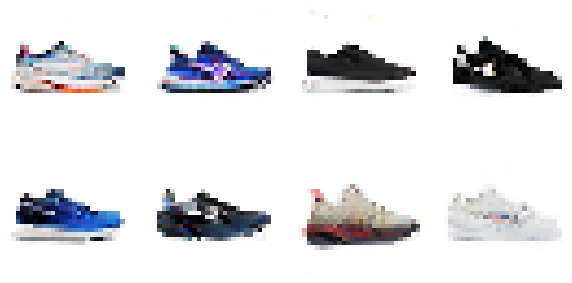

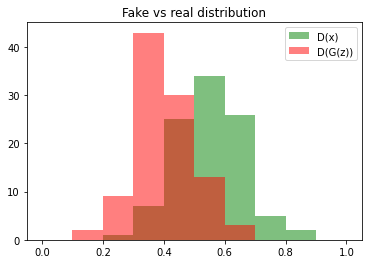

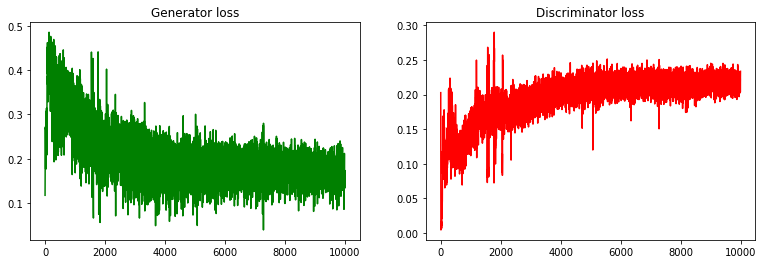

In [38]:
batch_size = 128
epochs = 10000

history = {"gen": [], "disc": []}

for epoch in range(epochs):

    # Generate a new batch of noise
    noise = sample_noise(batch_size)

    # Get a batch of real images
    real_data = sample_data(batch_size)

    # Generate a batch of fake images
    # Hint: use .predict() method
    fake_data = generator.predict(noise)

    # Run discriminator on both real and fake images
    # Hint: use .train_on_batch() method 
    data = tf.concat([real_data, fake_data], 0)
    labels = tf.concat([tf.ones(batch_size), tf.zeros(batch_size)], 0)
    loss_d = discriminator.train_on_batch(data, labels)

    # loss_d_real = discriminator.train_on_batch(real_data, tf.ones(batch_size)) # train on real_data
    # loss_d_fake = discriminator.train_on_batch(fake_data, tf.zeros(batch_size)) # train on fake_data
    # loss_d = 0.5 * (loss_d_real + loss_d_fake)

    # Make another noise batch
    noise = sample_noise(batch_size)

    # Train the generator to trick the discriminator
    # For the generator, we want all the {fake, not-fake} labels 
    # to say not-fake
    # Hint: use combined model
    loss_g = combined.train_on_batch(noise, tf.ones(batch_size))

    history["disc"].append(loss_d)
    history["gen"].append(loss_g)

    if (epoch + 1) % 100 == 0:
        clear_output(wait=True)
        print("Epoch:", epoch)
        
        sample_images(2, 4)
        sample_probas(100, batch_size)

        time = np.arange(epoch + 1)

        fig, ax = plt.subplots(ncols=2, figsize=(13, 4))
        ax[0].set_title("Generator loss")
        ax[0].plot(time, history["gen"], color='g')
        ax[1].set_title("Discriminator loss")
        ax[1].plot(time, history["disc"], color='r')
        plt.show()

Сохраним картинки для некоторой оценки:

In [39]:
all_fake_data = []
for _ in range(0, len(all_data), batch_size):
    fake_data = generator.predict(sample_noise(batch_size))
    all_fake_data.append(fake_data)

all_fake_data = np.concatenate(all_fake_data, 0)[:len(all_data)]
assert all_fake_data.shape == all_data.shape

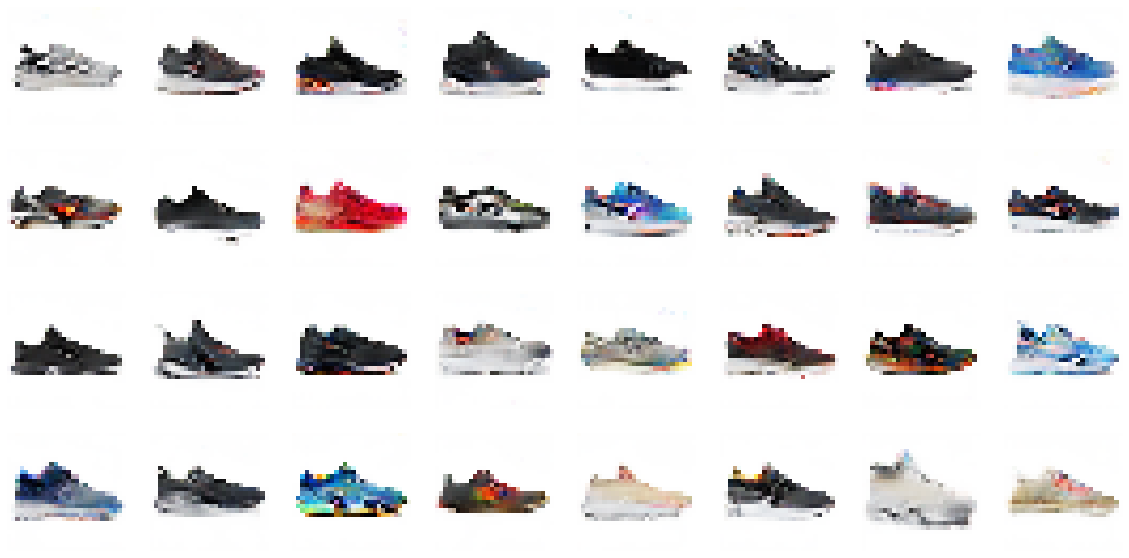

In [40]:
visualize_images(all_fake_data, 4, 8)

In [42]:
np.save("fake_data.npy", all_fake_data)

# 2. Super Resolution 

В этой части обучим GAN, который решает image-to-image problem: увеличивает качество изображение с низким разрешением.

Проще говоря, увеличим разрешение от 28x28 до 112x112.

In [43]:
LOW_RES_SIZE = IMAGE_SIZE
HIGH_RES_SIZE = (112, 112)

In [44]:
all_data_hr = np.stack([
    img2data(load_image(fn, HIGH_RES_SIZE))
    for fn in tqdm.tqdm(image_filenames, position=0)
])
assert all_data_hr.shape[1:] == HIGH_RES_SIZE + (3,)

100%|██████████| 5729/5729 [00:05<00:00, 1069.43it/s]


In [45]:
def sample_super_res_data(batch_size, low_res_size=LOW_RES_SIZE, high_res_size=HIGH_RES_SIZE):
    batch_ids = np.random.choice(len(all_data), size=batch_size)
    return all_data[batch_ids], all_data_hr[batch_ids]

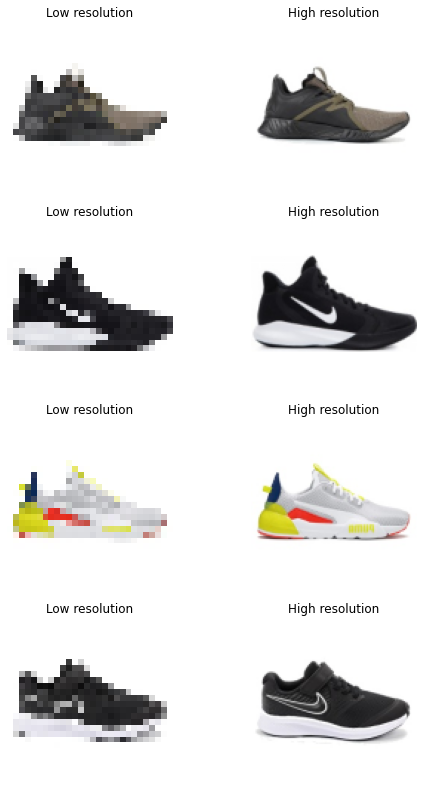

In [46]:
batch_size = 4
real_data_lr, real_data_hr = sample_super_res_data(batch_size)

assert real_data_lr.shape[1:] == LOW_RES_SIZE + (3,)
assert real_data_hr.shape[1:] == HIGH_RES_SIZE + (3,)

plt.figure(figsize=(8, 14))
for i in range(batch_size):
    plt.subplot(batch_size, 2, 2 * i + 1)
    plt.title("Low resolution")
    plt.imshow(data2img(real_data_lr[i]))
    plt.axis("off")

    plt.subplot(batch_size, 2, 2 * i + 2)
    plt.title("High resolution")
    plt.imshow(data2img(real_data_hr[i]))
    plt.axis("off")

plt.show()

Тут обучим [SRGAN](https://arxiv.org/abs/1609.04802)-like модель.

### Генератор

Для обучения SRGAN-генератора, нам нужен базовый Residual Block:

* Conv2D: 3x3, filters=filters, strides=1, padding="same"
* ReLU
* Batch Normalization with momentum(0.8)
* Conv2D: 3x3, filters=filters, strides=1, padding="same"
* Batch Normalization with momentum(0.8)
* Sum up outputs with inputs

In [47]:
def residual_block(inputs, filters, **kwargs):
    x = L.Conv2D(filters, 3, strides=1, padding='same')(inputs)
    x = L.BatchNormalization(momentum=0.8)(x)
    x = L.ReLU()(x)
    x = L.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = L.BatchNormalization(momentum=0.8)(x)

    outputs = inputs + x
    
    return outputs

... and an Upsampling Block(filters):

* UpSampling2D(2)
* Conv2D: 3x3, filters=filters, strides=1, padding="same"
* ReLU

In [48]:
def up_block(inputs, filters, **kwargs):
    x = L.UpSampling2D(2)(inputs)
    x = L.Conv2D(filters, 3, strides=1, padding='same')(x)
    
    outputs = L.ReLU()(x)
    
    return outputs

Теперь, имея basic building blocks, можем построить SRGAN-генератор:

In [49]:
def build_sr_generator():
    inputs = L.Input(shape=LOW_RES_SIZE + (3,))

    # An initial conv block
    x = L.Conv2D(64, kernel_size=9, strides=1, padding="same")(inputs)
    x = L.ReLU()(x)

    conv = x

    # 16 residual blocks with filters=64
    for block_num in range(16):
        x = residual_block(x, 64)

    # A post-residual block
    x = L.Conv2D(64, kernel_size=3, strides=1, padding="same")(x)
    x = L.BatchNormalization(momentum=0.8)(x)

    # Sum up current 'x' with 'conv' obtained earlier
    x = x + conv

    # Two upsampling blocks with filters=256
    x = up_block(x, 256)
    x = up_block(x, 256)

    # Final conv block
    x = L.Conv2D(3, kernel_size=9, strides=1, padding="same")(x)
    outputs = L.Activation("tanh")(x)
    
    return keras.models.Model(inputs=inputs, outputs=outputs, name="SRGAN_gen")

In [50]:
# Build SRGAN generator
generator = build_sr_generator()
generator.summary()

Model: "SRGAN_gen"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 28, 28, 64)   15616       input_9[0][0]                    
__________________________________________________________________________________________________
re_lu_4 (ReLU)                  (None, 28, 28, 64)   0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 28, 28, 64)   36928       re_lu_4[0][0]                    
__________________________________________________________________________________________

In [51]:
real_data_lr, real_data_hr = sample_super_res_data(32)
fake_data_hr = generator.predict(real_data_lr)
assert fake_data_hr.shape[1:] == HIGH_RES_SIZE + (3,)

### Дискриминатор

Определим базовый Block:

* Conv2D: 3x3, filters=filters, strides=strides, padding="same"
* Leaky ReLU(0.2)
* (optional) Batch Normalization with momentum(0.8) 

In [52]:
def d_block(inputs, filters, strides=1, apply_batchnorm=True, **kwargs):
    x = L.Conv2D(filters, 3, strides=strides, padding='same')(inputs)
    if apply_batchnorm:
      x = L.BatchNormalization(momentum=0.8)(x)
    
    outputs = L.LeakyReLU(0.2)(x)
    
    return outputs

Теперь можем построить SRGAN-дискриминатор:

* DBlock(filters=64, strides=1) with Batch Normalization
* DBlock(filters=64, strides=2)
* DBlock(filters=128, strides=1)
* DBlock(filters=128, strides=2)
* DBlock(filters=256, strides=1)
* DBlock(filters=256, strides=2)
* DBlock(filters=512, strides=1)
* DBlock(filters=512, strides=2)
* Flatten
* Полносвязный размера 1024
* Leaky ReLU(0.2)
* Полносвязный размера 1
* Сигмоида

In [53]:
def build_sr_discriminator():
    inputs = L.Input(shape=HIGH_RES_SIZE + (3,))

    x = d_block(inputs, 64, 1)
    x = d_block(x, 64, 2, apply_batchnorm=False)

    x = d_block(x, 128, 1, apply_batchnorm=False)
    x = d_block(x, 128, 2, apply_batchnorm=False)

    x = d_block(x, 256, 1, apply_batchnorm=False)
    x = d_block(x, 256, 2, apply_batchnorm=False)
    
    x = d_block(x, 512, 1, apply_batchnorm=False)
    x = d_block(x, 512, 2, apply_batchnorm=False)

    x = L.Flatten()(x)

    x = L.Dense(1024)(x)
    x = L.LeakyReLU(0.2)(x)

    outputs = L.Dense(1, activation='sigmoid')(x)

    return keras.models.Model(inputs=inputs, outputs=outputs, name="SRGAN_disc")

In [54]:
# Build SRGAN discriminator
discriminator = build_sr_discriminator()
discriminator.summary()

Model: "SRGAN_disc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 112, 112, 3)]     0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 112, 112, 64)      1792      
_________________________________________________________________
batch_normalization_43 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 56, 56, 128)       7

In [55]:
fake_probas = discriminator.predict(fake_data_hr)
assert fake_probas.shape[1:] == (1,)

In [56]:
real_data_lr, real_data_hr = sample_super_res_data(32)
real_probas = discriminator.predict(real_data_hr)

real_data = sample_data(32)

real_and_fake_data_hr = np.concatenate((real_data_hr, fake_data_hr))
real_and_fake_labels = np.array([1] * len(real_data_hr) + [0] * len(fake_data_hr))

real_and_fake_probas = discriminator.predict(real_and_fake_data_hr)

loss = discriminator_ls_loss(K.variable(real_and_fake_labels), K.variable(real_and_fake_probas))
assert loss.shape[1:] == ()
K.eval(loss)

0.25038433

In [57]:
def feature_loss(real_features, fake_features):
    # Implement MSE
    loss = K.mean((real_features - fake_features) ** 2)
    return loss

In [58]:
loss = feature_loss(K.variable(real_data_hr), K.variable(fake_data_hr))
assert loss.shape == ()
K.eval(loss)

1.0390791

In [92]:
generator = build_sr_generator()
discriminator = build_sr_discriminator()

discriminator_opt = keras.optimizers.Adam(1e-5, 0.5)
discriminator_loss = discriminator_ls_loss # you may choose any or try both. 
#By default, opt for the Least Squares GAN loss.

discriminator.compile(
    optimizer=discriminator_opt,
    loss=discriminator_loss
)

In [93]:
# we only want to be able to train generation for the combined model
discriminator.trainable = False

outputs = generator.outputs

combined = keras.models.Model(
    inputs=generator.inputs,
    outputs=[discriminator(generator.outputs), generator.outputs], # you should return both probas AND generated images
    name="SRGAN_combined"
)

feature_weight = 4

generator_opt = keras.optimizers.Adam(3e-4, 0.5)
generator_loss = [generator_ls_loss, feature_loss] # mind the order of outputs -- it should match the losses
loss_weights = [1, feature_weight]

combined.compile(
    optimizer=generator_opt,
    loss=generator_loss,
    loss_weights=loss_weights
)

In [61]:
def sample_images(n_samples):
    batch_size = n_samples
    real_data_lr, real_data_hr = sample_super_res_data(batch_size)
    fake_data_hr = generator.predict(real_data_lr)

    plt.figure(figsize=(11, int(3.5 * n_samples)))
    for i in range(batch_size):
        plt.subplot(n_samples, 3, 3 * i + 1)
        plt.title("Original LR")
        plt.imshow(data2img(real_data_lr[i]))
        plt.axis("off")

        plt.subplot(n_samples, 3, 3 * i + 3)
        plt.title("Generated HR")
        plt.imshow(data2img(fake_data_hr[i]))
        plt.axis("off")
        
        plt.subplot(n_samples, 3, 3 * i + 2)
        plt.title("Real HR")
        plt.imshow(data2img(real_data_hr[i]))
        plt.axis("off")

    plt.show()


def sample_probas(num_samples, batch_size):
    plt.title("Fake vs real distribution")
    
    real_probas, fake_probas = [], []

    for i in range(0, num_samples, batch_size):
        real_data_lr, real_data_hr = sample_super_res_data(batch_size)
        fake_data_hr = generator.predict(real_data_lr)
        
        real_probas.append(discriminator.predict(real_data_hr))
        fake_probas.append(discriminator.predict(fake_data_hr))

    real_probas = np.concatenate(real_probas, 0)[:num_samples]
    fake_probas = np.concatenate(fake_probas, 0)[:num_samples]

    plt.hist(real_probas, label="D(x)", alpha=0.5, range=[0,1], color='g')
    plt.hist(fake_probas, label="D(G(z))", alpha=0.5, range=[0,1], color='r')
    plt.legend(loc="best")
    plt.show()

### Training

Epoch: 4999


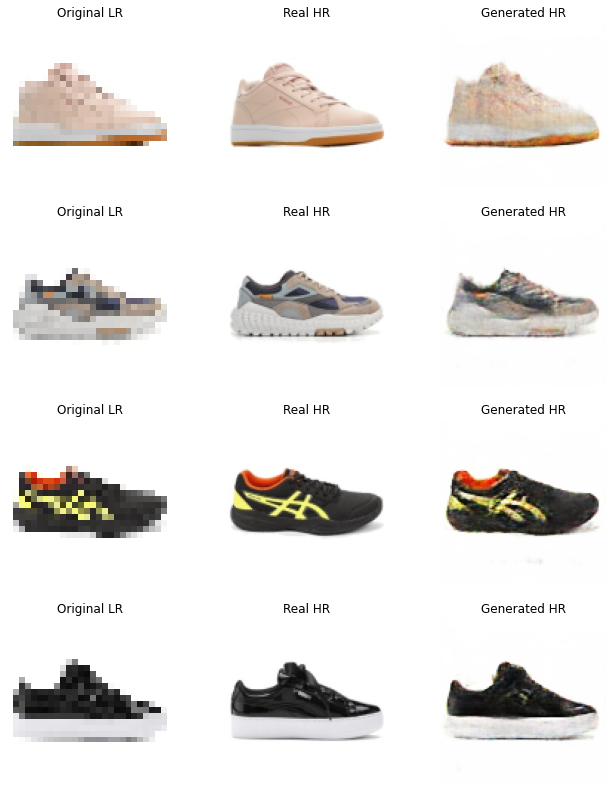

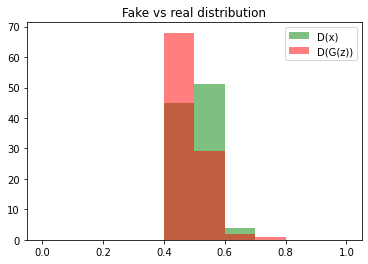

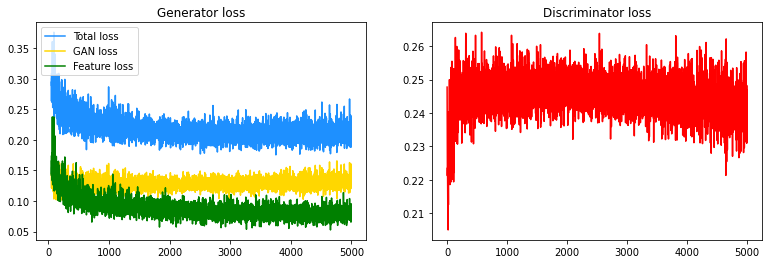

In [94]:
batch_size = 16
epochs = 5000

history = {"gen": [], "disc": []}

for epoch in range(epochs):

    # Sample low-res and high-res data
    real_data_lr, real_data_hr = sample_super_res_data(batch_size)

    # Generate high resolution images from low resolution ones
    fake_data_hr = generator.predict(real_data_lr)

    # Run discriminator on both real and fake high resolution images
    # loss_d_real = "???" # train on real_data_hr
    # loss_d_fake = "???" # train on fake_data_hr
    # loss_d = 0.5 * (loss_d_real + loss_d_fake)

    data = tf.concat([real_data_hr, fake_data_hr], 0)
    labels = tf.concat([tf.ones(batch_size), tf.zeros(batch_size)], 0)
    loss_d = discriminator.train_on_batch(data, labels)\

    # Sample another batch of low-res and high-res data
    real_data_lr, real_data_hr = sample_super_res_data(batch_size)

    # Train the generator to trick the discriminator
    # For the generator, we want all the {fake, not-fake} labels 
    # to say not-fake
    # Mind the number and the order of the outputs of the combined model!
    loss_g = combined.train_on_batch(real_data_lr, real_data_hr[np.newaxis, ])

    history["gen"].append(loss_g) 
    history["disc"].append(loss_d)

    if (epoch + 1) % 100 == 0:
        clear_output(wait=True)
        print("Epoch:", epoch)
        
        sample_images(4)
        sample_probas(100, batch_size)

        time = np.arange(epoch + 1)

        fig, ax = plt.subplots(ncols=2, figsize=(13, 4))
        ax[0].set_title("Generator loss")
        ax[0].plot(time[50:], [_[0] for _ in history["gen"][50:]], color="dodgerblue", label="Total loss")
        ax[0].plot(time[50:], [_[1] for _ in history["gen"][50:]], color="gold", label="GAN loss")
        ax[0].plot(time[50:], [feature_weight * _[2] for _ in history["gen"][50:]], color='g', label="Feature loss")
        ax[0].legend(loc="upper left")
        ax[1].set_title("Discriminator loss")
        ax[1].plot(time, history["disc"], color='r')
        plt.show()

Посмотрим на сгенерированные из подлинных низкокачественных изображений(`all_data`):

In [95]:
all_fake_data_from_real_lr = []
for index in tqdm.trange(0, len(all_data), batch_size, position=0):
    real_data_lr, real_data_hr = sample_super_res_data(batch_size) 
    fake_data_hr = generator.predict(real_data_lr)
    all_fake_data_from_real_lr.append(fake_data_hr)

all_fake_data_from_real_lr = np.concatenate(all_fake_data_from_real_lr, 0)[:len(all_data)]
assert all_fake_data_from_real_lr.shape == all_data_hr.shape

100%|██████████| 359/359 [00:26<00:00, 13.37it/s]


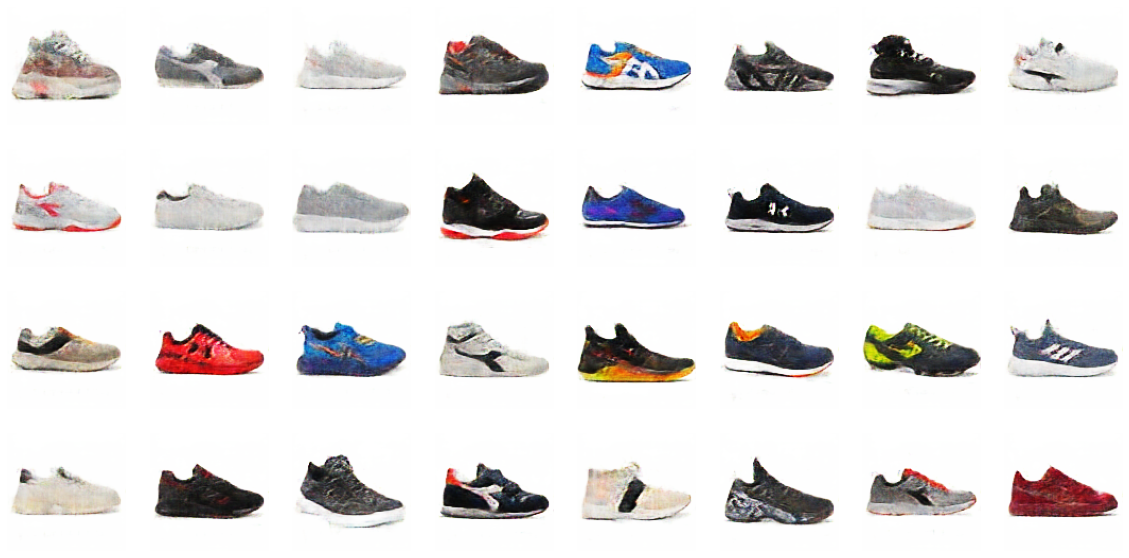

In [96]:
visualize_images(all_fake_data_from_real_lr, 4, 8)

In [97]:
np.save("fake_data_from_real_lr.npy", all_fake_data_from_real_lr)

Теперь из поддельных низкокачественных изображений(`all_fake_data`):

In [98]:
try:
    all_fake_data
except:
    all_fake_data = np.load("fake_data.npy")

In [99]:
all_fake_data_from_fake_lr = []
for index in tqdm.trange(0, len(all_data), batch_size, position=0):
    fake_data_lr = all_fake_data[index:index + batch_size]
    fake_data_hr = generator.predict(fake_data_lr)
    all_fake_data_from_fake_lr.append(fake_data_hr)

all_fake_data_from_fake_lr = np.concatenate(all_fake_data_from_fake_lr, 0)[:len(all_data)]
assert all_fake_data_from_fake_lr.shape == all_data_hr.shape

100%|██████████| 359/359 [00:27<00:00, 13.25it/s]


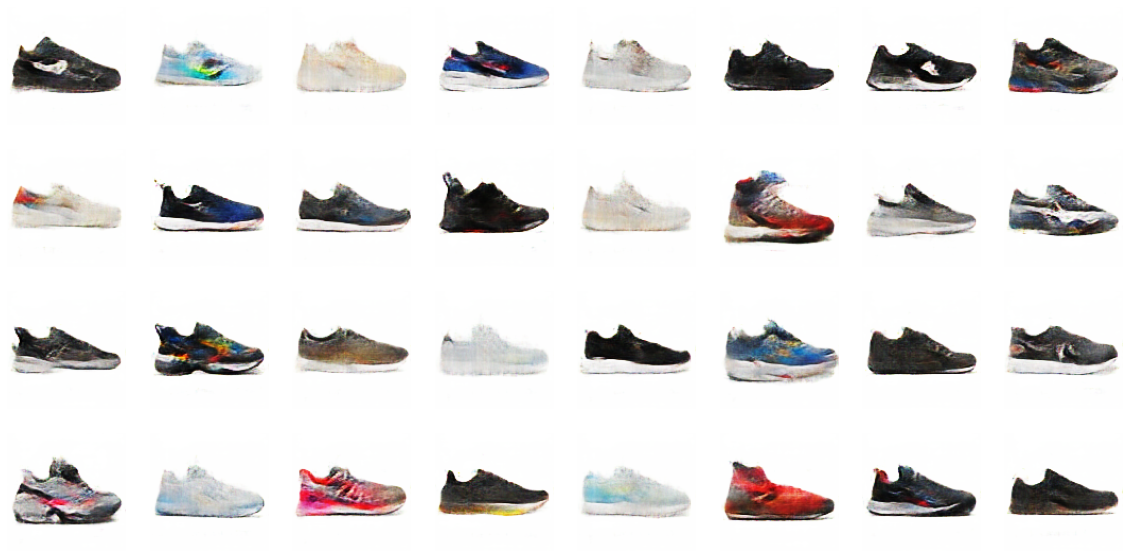

In [100]:
visualize_images(all_fake_data_from_fake_lr, 4, 8)

In [101]:
np.save("fake_data_from_fake_lr.npy", all_fake_data_from_fake_lr)

# 3. GAN-метрики

Существует несколько метрик, которые позволяют оценить качество обучению GAN'ов. Некоторые из них основаны на сравнении подлинных и созданных на их основе поддельных изображений.
Тут мы попробуем 2 метрики, а именно: [Precision-Recall Density](https://arxiv.org/pdf/1806.00035) и [Fréchet Inception Distance](https://arxiv.org/pdf/1706.08500). 

### Precision-Recall Density (PRD score)

In [102]:
from sklearn.cluster import KMeans, MiniBatchKMeans

def bin_counts(real_data, fake_data, n_bins=25):
    real_data = real_data.reshape(len(real_data), -1)
    fake_data = fake_data.reshape(len(fake_data), -1)

    data = np.vstack([real_data, fake_data])

    kmeans = MiniBatchKMeans(n_clusters=n_bins, n_init=10).fit(data)
    
    real_labels = kmeans.labels_[:len(real_data)]
    fake_labels = kmeans.labels_[len(real_data):]

    real_density = np.histogram(real_labels, bins=n_bins, range=[0, n_bins], density=True)[0]
    fake_density = np.histogram(fake_labels, bins=n_bins, range=[0, n_bins], density=True)[0]
    
    return real_density, fake_density

In [105]:
import math
from sklearn.metrics import auc

def calculate_alpha_beta(real_density, fake_density, n_thetas=1000):
    assert real_density.shape == fake_density.shape
    
    alpha = []
    beta = []
    
    thetas = np.linspace(1e-6, np.pi / 2 - 1e-6, num=n_thetas)
    for theta in thetas:
        tan = math.tan(theta)
        alpha.append(np.sum(np.minimum(theta * real_density, fake_density)))
        beta.append(alpha[-1] / theta)
    
    return alpha, beta

def calculate_precision_recall_density(real_densities, fake_densities, repeat_number=1000):
    vectors = np.array([
       calculate_alpha_beta(real_densities, fake_densities)
       for _ in range(repeat_number)
    ]).mean(axis=0)
    return vectors


def calculate_prd_score(real_data, fake_data):
    # Calculate bin counts from real and generated data
    real_density, fake_density =  bin_counts(real_data, fake_data, 30)

    plt.bar(range(len(real_density)), real_density, width=1, color='g', alpha=0.5, label="Real density")
    plt.bar(range(len(fake_density)), fake_density, width=1, color='r', alpha=0.5, label="Fake density")
    plt.legend()
    plt.show()

    # Calculate alpha and beta
    alpha, beta = calculate_precision_recall_density(real_density, fake_density)
    
    # Calculate area under curve (AUC) for alpha and beta
    score = auc(alpha, beta)

    return score, alpha, beta

Вычислим PRD-score для DCGAN(`all_data` и `all_fake_data`).

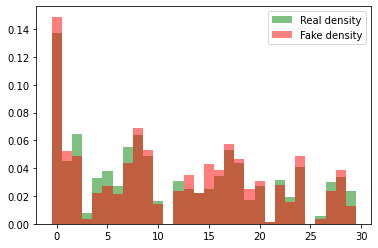

Score: 0.9724989783328726


In [106]:
score,  _, _ = calculate_prd_score(all_data, all_fake_data)
print("Score:", score)

Теперь используем PRD-score для сравнения высококачественных изображений сгенерированных из подлинных низкокачественных (`all_fake_data_from_real_lr`) и поддельных низкокачественных изображений (`all_fake_data_from_fake_lr`):

Generated from real LR


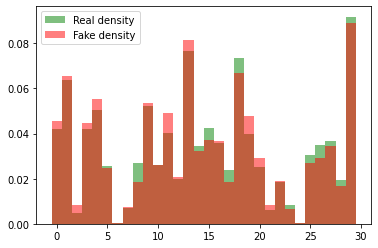

Score: 0.9913793431063387

Generated from fake LR


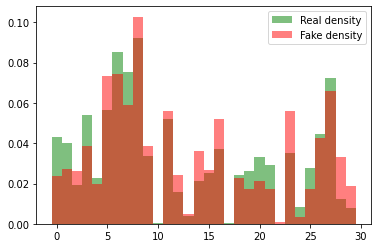

Score: 0.9344976703329428



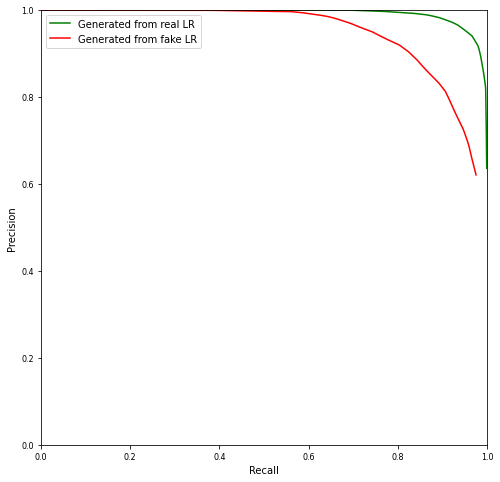

In [107]:
print("Generated from real LR")
score_real, alpha_real, beta_real = calculate_prd_score(all_data_hr, all_fake_data_from_real_lr)
print("Score:", score_real, end='\n\n')

print("Generated from fake LR")
score_fake, alpha_fake, beta_fake = calculate_prd_score(all_data_hr, all_fake_data_from_fake_lr)
print("Score:", score_fake, end='\n\n')

fig, ax = plt.subplots(figsize=(8, 8))
ax.tick_params(axis="both", which="major", labelsize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(alpha_real, beta_real, color='g', label="Generated from real LR")
plt.plot(alpha_fake, beta_fake, color='r', label="Generated from fake LR")
plt.legend()
plt.show()

### Fréchet Inception Distance (FID score)

[Frechet Inception Distance](https://arxiv.org/pdf/1706.08500) - продвинутая версия [Inception score](https://arxiv.org/abs/1606.03498), которая дополнительно считает некоторую оценку для подлинных данных, которую сравнивает с оценкой для сгенерированных данных. Это наиболее широко используемая метрика для оценки качества GAN'ов, которая полагается на фичи, извлечённые с помощью [InceptionV3](https://arxiv.org/abs/1512.00567), преобученной в ImageNet. Опуская выкладки, расстояние Fréchet'a может быть вычислено так:

$$\text{FID} = ||\mu_r - \mu_g||^2 + \text{Tr} (\Sigma_r + \Sigma_g - 2 (\Sigma_r \Sigma_g)^{1/2}),$$

где $X_r \sim \mathcal{N} (\mu_r, \Sigma_r)$ и $X_g \sim \mathcal{N} (\mu_g, \Sigma_g)$ - 2048-размерная активация Inception-v3 pool3-слоя для подлинного и сгенерированного примера.

Для начала создадим InceptionV3-модель.

In [108]:
base_inception = keras.applications.inception_v3.InceptionV3(weights="imagenet",
                                                             include_top=False,
                                                             pooling="avg")
inputs = L.Input(shape=(112, 112, 3))
outputs = base_inception(L.UpSampling2D(2)(inputs))

inception = keras.models.Model(inputs=inputs, outputs=outputs)
inception.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [109]:
real_data_lr, real_data_hr = sample_super_res_data(32)
assert inception.predict(real_data_hr).shape[1:] == (2048,)

In [110]:
def calculate_activations(data, batch_size=32, verbose=False):
    # Calculate activations of Pool3 layer of InceptionV3
    if verbose:
        print("Calculating activations...")
    activations = inception.predict(data, batch_size=batch_size, verbose=verbose)
    return activations

def calculate_activation_statistics(activations):
    # Calculate mean and covariance of activations. Mind the dimensions!
    mu = activations.mean(axis=0)
    sigma = np.cov(activations.T)
    return mu, sigma

In [111]:
real_activations = calculate_activations(all_data_hr, verbose=True)
real_mu, real_sigma = calculate_activation_statistics(real_activations)

assert real_mu.shape == (2048,)
assert real_sigma.shape == (2048, 2048)

Calculating activations...
180/180 [==============================] - 12s 67ms/step


In [112]:
import scipy

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    assert mu1.shape == mu2.shape
    assert sigma1.shape == sigma2.shape

    sigma1_sigma2 = scipy.linalg.sqrtm(np.dot(sigma1, sigma2))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(sigma1_sigma2):
        sigma1_sigma2 = sigma1_sigma2.real

    # Product might be almost singular
    if not np.isfinite(sigma1_sigma2).all():
        offset = np.eye(sigma1.shape[0]) * eps
        sigma1_sigma2 = scipy.linalg.sqrtm(np.dot(sigma1 + offset, sigma2 + offset))

    diff = mu1 - mu2
    return np.linalg.norm(diff) ** 2 + np.trace(sigma1 + sigma2 - 2 * sigma1_sigma2) # use diff, sigma1, sigma2 to calculate FID according to the formula above


def calculate_fid_score(real_data, fake_data, verbose=False):
    # Run inception on real and fake data to obtain activations
    real_activations = calculate_activations(real_data, verbose=True)
    fake_activations = calculate_activations(fake_data, verbose=True)

    # Calculate mu and sigma for both real and fake activations
    real_mu, real_sigma = calculate_activation_statistics(real_activations)
    fake_mu, fake_sigma = calculate_activation_statistics(fake_activations)

    return calculate_frechet_distance(real_mu, real_sigma, fake_mu, fake_sigma) # calculate Frechet distance

Посчитаем FID-score между `all_data_hr` и `all_fake_data_from_real_hr`:

In [113]:
score = calculate_fid_score(all_data_hr, all_fake_data_from_real_lr)
print("Score:", score)

Calculating activations...
180/180 [==============================] - 12s 67ms/step
Calculating activations...
180/180 [==============================] - 12s 69ms/step
Score: 386.2701282215116


Складывая всё вместе: посчитаем FID-score между `all_data_hr` и `all_fake_data_from_fake_hr`:

In [114]:
score = calculate_fid_score(all_data_hr, all_fake_data_from_fake_lr)
print("Score:", score)

Calculating activations...
180/180 [==============================] - 12s 64ms/step
Calculating activations...
180/180 [==============================] - 12s 65ms/step
Score: 509.2490026389674
